In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D, ELU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, Adam

from scipy.ndimage import gaussian_filter1d
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

# Show multiple outputs of one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# I Don't care...
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

tf.config.list_physical_devices('GPU')
tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

'/device:GPU:0'

# Compute Receptive Field for a given net
Another version, which I use when calculating it manually, like we did during the lecture, is attached at the end of that notebook. (It was inefficient though)

In [3]:
def compute_receptive_field(model, verbose=1):
    """
    Create a list of receptive field value in all layers of a specified model. 
    Each index represents a tuple indicates the size of a receptive field in the corresponding layer.
    
    Args:
        model: A sequential model to compute Receptive Fields for its layers
        
    Returns:
        RF: list of tuples where each element represents the Receptive Field at its corresponding layer.
    """
    def debug(messageSupplier):
        if verbose > 1:
            print(messageSupplier())
            
    def countEffectiveLayers(net):
        count = 0
        for curr_layer in net.layers:
            if isinstance(curr_layer, Flatten):
                break
            count += 1
        return count
            
    def safeGetKernelAndStride(layer):
        kernel_size = None
        strides = None

        # For Conv2D
        if hasattr(layer, 'kernel_size'):
            kernel_size = layer.kernel_size
        # For MaxPooling
        elif hasattr(layer, 'pool_size'):
            kernel_size = layer.pool_size

        # Take strides into consideration as well
        if hasattr(layer, 'strides'):
            strides = layer.strides
        if strides is None:
            strides = kernel_size
        
        # keras supports kernel and strides as single integer, and not necessarily a tuple/list.
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(strides, int):
            strides = (strides, strides)
        
        return kernel_size, strides
    
    
    RF = []
    
    # Index cause each layer depends on its previous layer, so we can look at i-1
    i = -1
    
    # Measure distance between the center of two kernels, considering the stride, cause this distance is added to RF value.
    # Measurement is applied both horizontally (X) and vertically (Y), so we can update the two values of receptive field, independently.
    distance_x_in = 1
    distance_y_in = 1
    
    layersCount = countEffectiveLayers(model)
    debug(lambda: f'Computing receptive field for {layersCount} layers. As a result, there will be {layersCount} receptive field values.')
    for curr_layer in model.layers:
        i += 1
        
        # Stop iterating when we get to Flatten or Dropout layer.
        if isinstance(curr_layer, Flatten):
            debug(lambda: 'Arrived to "Flatten" layer. Stopping receptive field computation.')
            break
        
        # For first layer, just take the kernel value as is, cause there was no stride.
        if i == 0:
            RF.append(curr_layer.kernel_size)
        # Otherwise, calculate the receptive field value based on previous value + distance measurement
        else:
            kernel_size, strides = safeGetKernelAndStride(curr_layer)

            # I don't know.. Just keep same RF
            if kernel_size is None:
                debug(lambda: f'No "kernel_size" or "pool_size" in layer "{curr_layer.name}". As a result, receptive field is kept as previous layer: {RF[i - 1]}')
                RF.append(RF[i - 1])
                continue

            # Update RF for current layer
            rf_x = RF[i - 1][0] + ((kernel_size[0] - 1) * distance_x_in)
            rf_y = RF[i - 1][1] + ((kernel_size[1] - 1) * distance_y_in)
            RF.append((rf_x, rf_y))
            
            # Update distances, for next iteration
            distance_x_in, distance_y_in = distance_x_in * strides[0], distance_y_in * strides[1]
    
    return RF

### Load a dataset

In [24]:
# batch_size is -1 so we will have all data in memory. Easier to transform to nparray
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True, batch_size=-1)
(X_train, y_train) = tfds.as_numpy(ds_train)
(X_test, y_test) = tfds.as_numpy(ds_test)

X_train = np.float64(X_train) / 255.
X_test = np.float64(X_test) / 255.

# Input shape. This is not the actual shape of images in mnist. Actual shape is (28, 28, 1)
img_shape = ds_info.features['image'].shape
print(ds_info.citation.title())
print('Image shape:', img_shape)
print('Train dataset examples:', f'{ds_info.splits["train"].num_examples:,}')
print('Test dataset examples:', f'{ds_info.splits["test"].num_examples:,}')


@Online{Clanuwat2018Deep,
  Author       = {Tarin Clanuwat And Mikel Bober-Irizar And Asanobu Kitamoto And Alex Lamb And Kazuaki Yamamoto And David Ha},
  Title        = {Deep Learning For Classical Japanese Literature},
  Date         = {2018-12-03},
  Year         = {2018},
  Eprintclass  = {Cs.Cv},
  Eprinttype   = {Arxiv},
  Eprint       = {Cs.Cv/1812.01718},
}
Image shape: (28, 28, 1)
Train dataset examples: 60,000
Test dataset examples: 10,000


### Build several models for tests

In [5]:
def build_vgg_model(input_shape, num_classes=10):
    """
    Create the VGG CNN model.
    I use this model only for seeing the receptive field values. Cannot use it for kmnist as the input images are too small.
    
    Author: K. Simonyan and A. Zisserman from the University of Oxford
        
    Returns:
        model: The model
    """
    model = Sequential(name="VGG16")
    model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dense(num_classes))

    model.compile(optimizer=Adadelta(learning_rate=1.0), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalAccuracy()])
    return model

In [6]:
def build_aakashnain_model(input_shape, num_classes=10):
    """
    Create a CNN model having more than 1M trainable parameters.
    
    Author: https://www.kaggle.com/code/aakashnain/kmnist-mnist-replacement/notebook
        
    Returns:
        model: The model
    """
    model = Sequential(name="aakashnain")
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))

    model.compile(optimizer=Adadelta(learning_rate=1.0), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalAccuracy()])
    return model

In [7]:
def build_dr_igor_no_pooling_model(input_shape, num_classes=10):
    """
    Create a CNN model with no pooling, as uploaded to Moodle (dl_hit_mnist_cnn)
    
    Author: Dr. Igor Nor
        
    Returns:
        model: The model
    """
    layers = [
        Conv2D(filters=16, kernel_size=(3, 3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00001), input_shape=input_shape),
        BatchNormalization(),
        ELU(),
        Dropout(0.2),

        Conv2D(filters=16, kernel_size=(3, 3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00001)),
        BatchNormalization(),
        ELU(),
        Dropout(0.2),

        Conv2D(filters=16, kernel_size=(3, 3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00001)),
        BatchNormalization(),
        ELU(),
        Dropout(0.2),

        Flatten(),
        Dense(num_classes, kernel_initializer='he_normal')
    ]

    model = Sequential(layers, name="DrIgorNoPooling")
    model.compile(optimizer=Adam(0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalAccuracy()])
    return model

In [8]:
def build_dr_igor_with_pooling_model(input_shape, num_classes=10):
    """
    Create a CNN model with pooling, as uploaded to Moodle (dl_hit_mnist_cnn)
    
    Author: Dr. Igor Nor
        
    Returns:
        model: The model
    """
    layers = [
        Conv2D(filters=16, kernel_size=(3, 3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00001), input_shape=input_shape),
        BatchNormalization(),
        ELU(),
        Dropout(0.2),

        MaxPooling2D(),

        Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00001)),
        BatchNormalization(),
        ELU(),
        Dropout(0.2),

        MaxPooling2D(),

        Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.00001)),
        BatchNormalization(),
        ELU(),
        Dropout(0.2),

        Flatten(),
        Dense(10, kernel_initializer='he_normal')
    ]

    model = Sequential(layers, name="DrIgorWithPooling")
    model.compile(optimizer=Adam(0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalAccuracy()])
    return model

# Display nets and Receptive Field data and stats
Note that I added a "Rceptive Field" column to the model.summary() method, to map each RF to its layer

In [9]:
def buildModelAndSummarize(builder, *builder_params):
    def summaryPrint(line):
        additionalString = ''
        
        # Define the linesCount variable as non-local, causing it to bind
        # to the nearest non-global variable also called linesCount.
        nonlocal linesCount
        
        RF_width = 22
        
        if len(line.strip()) > 0:
            if linesCount > 3 and linesCount < (len(receptive_field) + 4):
                additionalString = f'  {str(receptive_field[linesCount-4]):{RF_width}s}'
            elif linesCount == 1:
                additionalString = '_' * RF_width
            elif linesCount == 2:
                additionalString = '  Receptive Field'
            elif linesCount == 3:
                additionalString = '=' * RF_width
            linesCount += 1
        
        print(line + additionalString)
            
        
    model = builder(*builder_params)
    receptive_field = compute_receptive_field(model, verbose=2)
    linesCount = 0
    
    print(f'\nReceptive Field: (Legth={len(receptive_field)})\n', receptive_field)
    
    print('\n')
    model.summary(line_length=100, print_fn=summaryPrint)

    return model, receptive_field

In [10]:
model, receptive_field = buildModelAndSummarize(build_vgg_model, img_shape)

Computing receptive field for 18 layers. As a result, there will be 18 receptive field values.
Arrived to "Flatten" layer. Stopping receptive field computation.

Receptive Field: (Legth=18)
 [(3, 3), (5, 5), (6, 6), (10, 10), (14, 14), (16, 16), (24, 24), (32, 32), (40, 40), (44, 44), (60, 60), (76, 76), (92, 92), (100, 100), (132, 132), (164, 164), (196, 196), (212, 212)]


Model: "VGG16"
__________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #          Receptive Field
 conv2d (Conv2D)                             (None, 224, 224, 64)                    1792             (3, 3)                
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 224, 224, 64)                    36928            (5, 5)                
               

In [25]:
model_aakashnain, receptive_field = buildModelAndSummarize(build_aakashnain_model, img_shape)

Computing receptive field for 4 layers. As a result, there will be 4 receptive field values.
No "kernel_size" or "pool_size" in layer "dropout_8". As a result, receptive field is kept as previous layer: (6, 6)
Arrived to "Flatten" layer. Stopping receptive field computation.

Receptive Field: (Legth=4)
 [(3, 3), (5, 5), (6, 6), (6, 6)]


Model: "aakashnain"
__________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #          Receptive Field
 conv2d_21 (Conv2D)                          (None, 26, 26, 32)                      320              (3, 3)                
                                                                                                    
 conv2d_22 (Conv2D)                          (None, 24, 24, 64)                      18496            (5, 5)                
                                                

In [12]:
model_no_pooling, receptive_field = buildModelAndSummarize(build_dr_igor_no_pooling_model, img_shape)

Computing receptive field for 12 layers. As a result, there will be 12 receptive field values.
No "kernel_size" or "pool_size" in layer "batch_normalization". As a result, receptive field is kept as previous layer: (3, 3)
No "kernel_size" or "pool_size" in layer "elu". As a result, receptive field is kept as previous layer: (3, 3)
No "kernel_size" or "pool_size" in layer "dropout_2". As a result, receptive field is kept as previous layer: (3, 3)
No "kernel_size" or "pool_size" in layer "batch_normalization_1". As a result, receptive field is kept as previous layer: (5, 5)
No "kernel_size" or "pool_size" in layer "elu_1". As a result, receptive field is kept as previous layer: (5, 5)
No "kernel_size" or "pool_size" in layer "dropout_3". As a result, receptive field is kept as previous layer: (5, 5)
No "kernel_size" or "pool_size" in layer "batch_normalization_2". As a result, receptive field is kept as previous layer: (7, 7)
No "kernel_size" or "pool_size" in layer "elu_2". As a result,

In [13]:
model_with_pooling, receptive_field = buildModelAndSummarize(build_dr_igor_with_pooling_model, img_shape)

Computing receptive field for 14 layers. As a result, there will be 14 receptive field values.
No "kernel_size" or "pool_size" in layer "batch_normalization_3". As a result, receptive field is kept as previous layer: (3, 3)
No "kernel_size" or "pool_size" in layer "elu_3". As a result, receptive field is kept as previous layer: (3, 3)
No "kernel_size" or "pool_size" in layer "dropout_5". As a result, receptive field is kept as previous layer: (3, 3)
No "kernel_size" or "pool_size" in layer "batch_normalization_4". As a result, receptive field is kept as previous layer: (8, 8)
No "kernel_size" or "pool_size" in layer "elu_4". As a result, receptive field is kept as previous layer: (8, 8)
No "kernel_size" or "pool_size" in layer "dropout_6". As a result, receptive field is kept as previous layer: (8, 8)
No "kernel_size" or "pool_size" in layer "batch_normalization_5". As a result, receptive field is kept as previous layer: (18, 18)
No "kernel_size" or "pool_size" in layer "elu_5". As a r

# Visualize data using t-SNE dimension reduction strategy

In [14]:
def visualize_kmnist(model1, X_train, y_train, index=0, n_samples=10000):
    # Get a t-SNE instance, reducing to 2D
    tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, init='pca', random_state=42)
    
    # Clone model without last layer, to get the output features of the model.
    layers = []
    for i in range(len(model1.layers) - 1):
        layers.append(model1.layers[i])
    model_copy = Sequential(layers)
    model_copy.compile(optimizer=model1.optimizer, loss=model1.loss, metrics=model1.metrics)
    model_copy.set_weights(model1.get_weights()[:-2])

    # Fit tsne to the data
    X_for_demo = X_train[:n_samples]
    y_for_demo = y_train[:n_samples]
    
    y_pred = model_copy.predict(X_for_demo)
    #X_2D = y_predict.reshape(y_predict.shape[0],)
    X_2D = y_pred
    X_2D = tsne.fit_transform(X_2D)

    ax = None
    if index > 0:
        ax = plt.subplot(1, 2, index)
        
    colors = list(mcolors.TABLEAU_COLORS.values())

    for i in range(10):
        curr_group = y_for_demo == i
        x, y = X_2D[curr_group, 0], X_2D[curr_group, 1]
        sns.scatterplot(x=x, y=y, label=i, s=32, color=colors[i], alpha=0.4, ax=ax)

    plt.title('\nVisualizing KMNIST embeddings using t-SNE\n', fontweight='bold', fontsize=26, color='tab:blue')
    plt.legend()

### Helper method used to subplot a history diagram (accuracy / loss)

In [15]:
def plot_history(hist, histDotted, histLabel, histDottedLabel, ylabel, title='', color='', index=0):
    def adjust_lightness(color, amount=1.7):
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        
        if c is None or (isinstance(c, str) and c == ''):
            return ''
        
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
    if index > 0:
        plt.subplot(1, 2, index)
    
    # Smooth the line using gaussian blur
    lastValBeforeSmooth = hist[-1]
    # hist = gaussian_filter1d(hist, sigma=1.2)
    # histDotted = gaussian_filter1d(histDotted, sigma=1.2)
    plt.plot(histDotted, '.--', c=adjust_lightness(color), label=histDottedLabel)
    plt.plot(hist, '.-', c=color, label=histLabel)
    plt.ylim([0, max(1, max(np.max(hist), np.max(histDotted)) + 0.2)])
    plt.title('\n' + title + ' {:.4f}'.format(lastValBeforeSmooth) + '\n', fontweight='bold', fontsize=26, color='tab:blue')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    plt.grid()

In [16]:
def plot_confusion_matrix(y_test, y_predict, index=0):
    ax = None
    if index > 0:
        ax = plt.subplot(1, 2, index)  
        
    conf_mat = confusion_matrix(y_test, y_predict)
    plt.style.use('seaborn-deep')
    heatmap = sns.heatmap(conf_mat, annot=True, annot_kws={'size': 15}, linewidths=0.5, fmt="d", cmap=plt.cm.Blues, ax=ax)
    heatmap.set_xlabel('Predicted', fontsize=16)
    heatmap.set_ylabel('Actual', fontsize=16)
    heatmap.xaxis.set_ticks_position('top')
    heatmap.xaxis.set_label_position('top')
    plt.title('\nConfusion Matrix on KMNIST predictions\n', fontweight='bold', fontsize=26, color='tab:blue')

### Plot accuracy and loss diagram for both model and validation

In [17]:
def plot_accuracy_and_loss(model, history, X_test, y_test):
    # Plot accuracy
    accuracyData = history.history['sparse_categorical_accuracy']
    valAccuracyData = history.history['val_sparse_categorical_accuracy']
    lossData = history.history['loss']
    valLossData = history.history['val_loss']
    
    fig = plt.figure(figsize=(25, 8))
    plot_history(valAccuracyData, accuracyData, 'validation', 'training', ylabel='Accuracy', title='Accuracy:', color='tab:blue', index=1)
    plot_history(valLossData, lossData, 'validation', 'training', ylabel='Loss', title='Loss:', color='tab:red', index=2)
    plt.show()
    
    # Predict results on test data set, to draw confusion matrix
    y_predict = model.predict(X_test)
    
    # Get the index of maximum value in the encoded vector
    y_predict = np.argmax(y_predict, axis=1)
    fig = plt.figure(figsize=(25, 8))
    plot_confusion_matrix(y_test, y_predict, index=1)
    print('Visualizing data might take some time. Please wait...')
    visualize_kmnist(model, X_train, y_train, index=2)
    plt.show()

# Net Simulation and Stats

In [26]:
history = model_aakashnain.fit(X_train, y_train, batch_size=128, epochs=12, validation_data=(X_test, y_test))

Epoch 1/12
469/469 [==============================] - 11s 24ms/step - loss: 0.4388 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.3722 - val_sparse_categorical_accuracy: 0.8912
Epoch 2/12
469/469 [==============================] - 11s 24ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.2910 - val_sparse_categorical_accuracy: 0.9145
Epoch 3/12
469/469 [==============================] - 11s 24ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.2569 - val_sparse_categorical_accuracy: 0.9287
Epoch 4/12
469/469 [==============================] - 11s 24ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.2407 - val_sparse_categorical_accuracy: 0.9346
Epoch 5/12
469/469 [==============================] - 12s 25ms/step - loss: 0.0896 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.2290 - val_sparse_categorical_accuracy: 0.9411
Epoch 6/12
469/469 [==============================] - 11s 24ms/step - loss: 0.0789 - spars

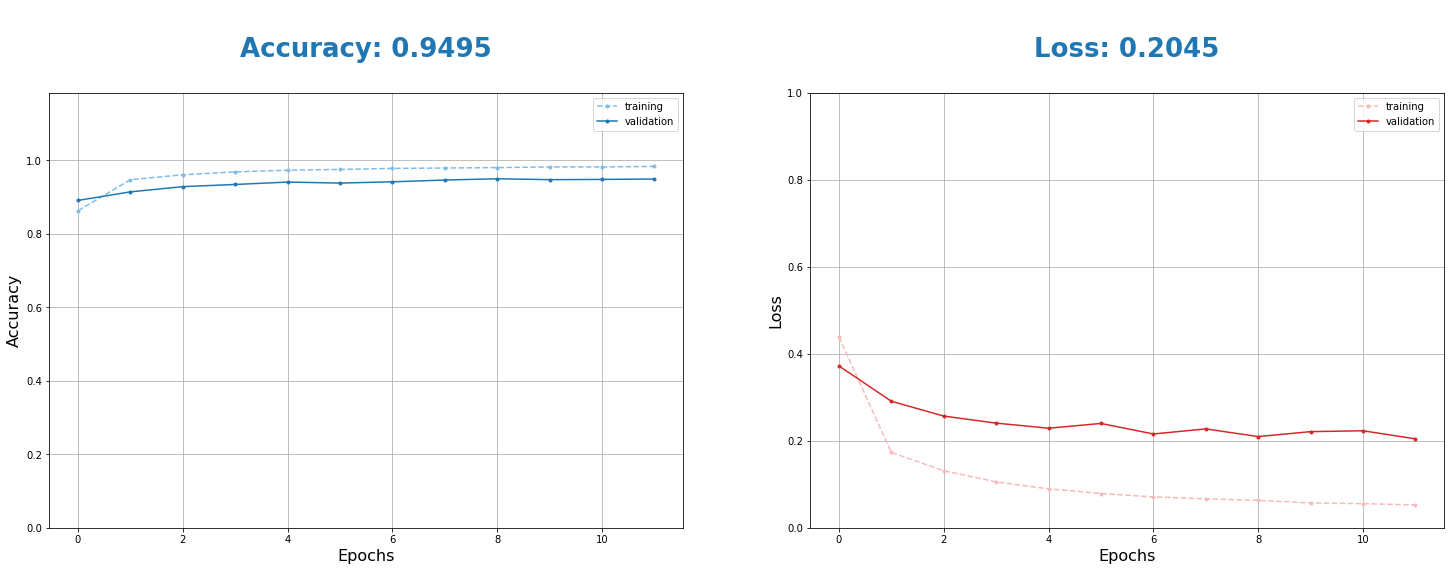

Visualizing data might take some time. Please wait...


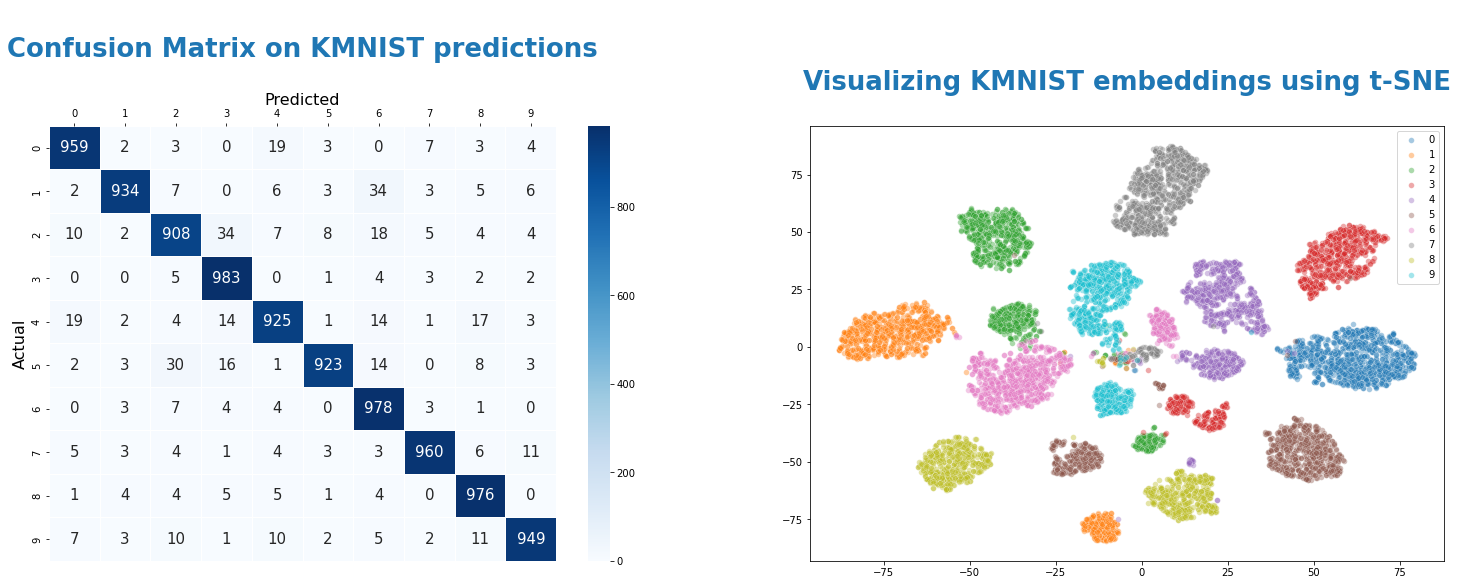

In [27]:
plot_accuracy_and_loss(model_aakashnain, history, X_test, y_test)

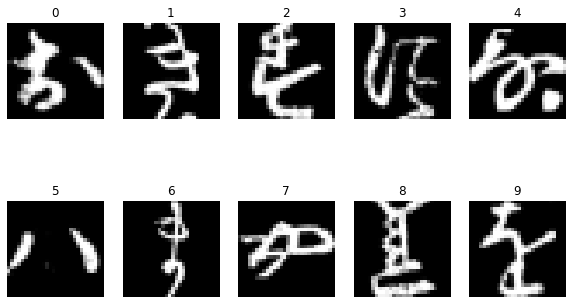

In [20]:
def show_image(ax, samples, x, y):
    digit = 5 * y + x
    ax[y, x].imshow(samples[digit], cmap='gray')
    ax[y, x].set_title(str(digit))
    ax[y, x].axis('off')
    ax[y, x].set_aspect('equal')


samples = []
images = np.reshape(X_train, (X_train.shape[0], 28, 28))
for i in range(10):
    samples.append(images[y_train==i][0])

# Converting list into a numpy array
samples = np.array(samples)

# Visualize the samples
f, ax = plt.subplots(2, 5, figsize=(10, 6))
show_image(ax, samples, 0, 0)
show_image(ax, samples, 1, 0)
show_image(ax, samples, 2, 0)
show_image(ax, samples, 3, 0)
show_image(ax, samples, 4, 0)
show_image(ax, samples, 0, 1)
show_image(ax, samples, 1, 1)
show_image(ax, samples, 2, 1)
show_image(ax, samples, 3, 1)
show_image(ax, samples, 4, 1)
plt.show()

In [23]:
# This is the first implementation, translating the computation we have done during the lecture, to code.
# It is less efficient though. O(L^2), hence I chose the better formulae above.
def class_computation_of_receptive_field(model):
    def do_out_on_one_dim(kernel1, stride1, r_in1):
        if r_in1 == 1:
            r_out = kernel1
        elif stride1 < kernel1:
            r_out = (r_in1 * kernel1) - ((kernel1 - stride1) * (r_in1 - 1))
        else:
            r_out = (kernel1 * r_in1) + (r_in1 - 1) * (stride1 - kernel1)
        return r_out
    
    def out_r_from_in(kernel, stride, r_in):
        r_out_x = do_out_on_one_dim(kernel[0], stride[0], r_in[0])
        r_out_y = do_out_on_one_dim(kernel[1], stride[1], r_in[1])
        return (r_out_x, r_out_y)
    
    def collect_convolutional_layers(model):
        layers = []
        for curr_layer in model.layers:
            if isinstance(curr_layer, Conv2D) or isinstance(curr_layer, MaxPool2D) or isinstance(curr_layer, MaxPooling2D):
                layers.append(curr_layer)
        return layers
            
    def safeGetKernelAndStride(layer):
        kernel_size = None
        strides = None

        # For Conv2D
        if hasattr(layer, 'kernel_size'):
            kernel_size = layer.kernel_size
        # For MaxPooling
        elif hasattr(layer, 'pool_size'):
            kernel_size = layer.pool_size

        # Take strides into consideration as well
        if hasattr(layer, 'strides'):
            strides = layer.strides
        if strides is None:
            strides = kernel_size
        
        return kernel_size, strides


    receptive_fields = []
    layers = collect_convolutional_layers(model)

    # Now append the kernel of first layer as the receptive field of it.
    receptive_fields.append(safeGetKernelAndStride(layers[0])[0])
    
    for i in range(1, len(layers)):
        curr_last_layer = layers[i]
        last_kernel, strides = safeGetKernelAndStride(curr_last_layer)
        layer_rs = [(last_kernel[0], last_kernel[1])]
        k = 0
        for j in range(i - 1, -1, -1):
            curr_layer = layers[j]
            kernel_size, strides = safeGetKernelAndStride(curr_layer)
            if kernel_size is None:
                layer_rs.append(layer_rs[k])
            else:
                layer_rs.append(out_r_from_in(kernel_size, strides, layer_rs[k]))
            k += 1
        receptive_fields.append(layer_rs[len(layer_rs) - 1])

    summary_title = f'---------- Receptive Field for model "{model.name}" ----------'
    print (summary_title)
    print(receptive_fields)
    print ("-" * len(summary_title) + "\n")


class_computation_of_receptive_field(model)
class_computation_of_receptive_field(model_aakashnain)
class_computation_of_receptive_field(model_no_pooling)
class_computation_of_receptive_field(model_with_pooling)

---------- Receptive Field for model "VGG16" ----------
[(3, 3), (5, 5), (6, 6), (10, 10), (14, 14), (16, 16), (24, 24), (32, 32), (40, 40), (44, 44), (60, 60), (76, 76), (92, 92), (100, 100), (132, 132), (164, 164), (196, 196), (212, 212)]
-------------------------------------------------------

---------- Receptive Field for model "aakashnain" ----------
[(3, 3), (5, 5), (6, 6)]
------------------------------------------------------------

---------- Receptive Field for model "DrIgorNoPooling" ----------
[(3, 3), (5, 5), (7, 7)]
-----------------------------------------------------------------

---------- Receptive Field for model "DrIgorWithPooling" ----------
[(3, 3), (4, 4), (8, 8), (10, 10), (18, 18)]
-------------------------------------------------------------------

